# <font color="magenta">Control del Stock</font>

Planificación, cálculo y confección de un esquema orientado al control del stock.


Este Notebook se desarrolló en <font color="76A7FA">**BigQuery**</font> y por lo tanto, la mayoría del código contiene consultas SQL.

El resultado final es un conjunto de tablas que forman parte de una base de datos y la confección automática de una lista de productos a controlar cuando sea requerida.

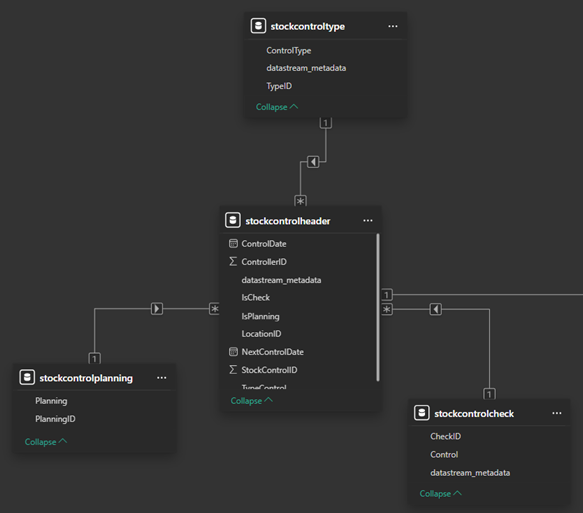

Base de Datos Final.
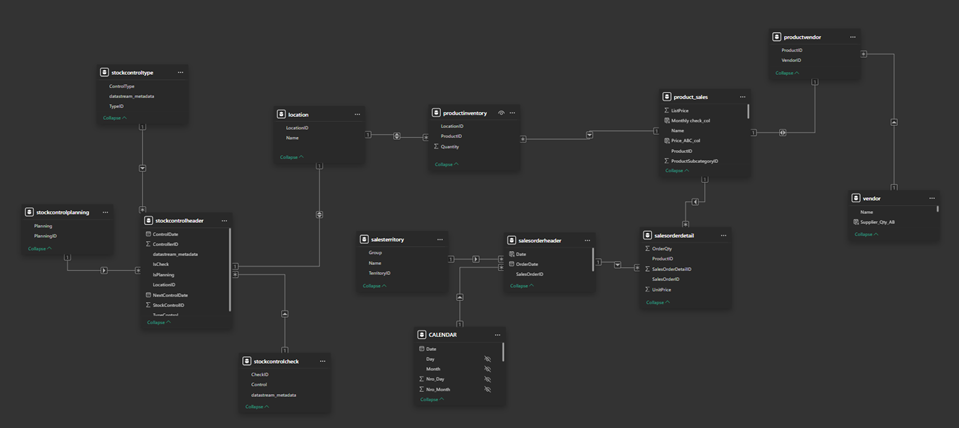

Ejemplo de la lista de productos que se deben controlar el 14 de Julio del 2004.

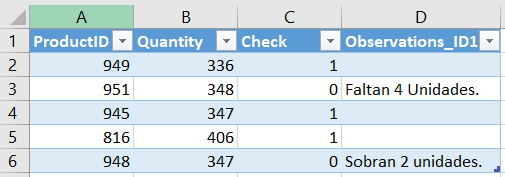

## <font color="magenta">Análisis de Pareto</font>

Se realiza un análisis de Pareto sobre los productos para determinar su nivel de importancia en el negocio, los productos prioritarios se controlan dos veces por mes y el resto una vez al mes.

Este análisis se efectúa sobre las cantidades vendidas, el precio y los ingresos que generan los productos.

Y utilizando los registros de los últimos 3 meses.

In [ ]:
# Ventas últimos 3 meses
%%bigquery
SELECT * FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`
WHERE DATE_DIFF(
               (SELECT DATE(MAX(OrderDate)) FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`),
               DATE(OrderDate),
               MONTH
                ) < 3
ORDER BY OrderDate ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,SalesOrderID,OrderDate,TerritoryID
0,69712,2004-05-01 22:00:00+00:00,1
1,69688,2004-05-01 22:00:00+00:00,4
2,69675,2004-05-01 22:00:00+00:00,4
3,69681,2004-05-01 22:00:00+00:00,1
4,69684,2004-05-01 22:00:00+00:00,1
5,69714,2004-05-01 22:00:00+00:00,4
6,69713,2004-05-01 22:00:00+00:00,4
7,69705,2004-05-01 22:00:00+00:00,4
8,69700,2004-05-01 22:00:00+00:00,1
9,69703,2004-05-01 22:00:00+00:00,1


In [ ]:
# Productos vendidos
%%bigquery
SELECT * FROM `our-pursuit-431019-r0.adventureworks.salesorderdetail`
WHERE SalesOrderID IN (
                        SELECT SalesOrderID FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`
                        WHERE DATE_DIFF(
                                        (SELECT DATE(MAX(OrderDate)) FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`),
                                        DATE(OrderDate),
                                        MONTH
                                          ) < 3
                        ) limit 10

Query is running:   0%|          |

Downloading:   0%|          |

,SalesOrderID,SalesOrderDetailID,OrderQty,ProductID,UnitPrice
0,72737,115573,1,779,2319.99
1,72910,116014,1,779,2319.99
2,73152,116597,1,779,2319.99
3,72820,115788,1,779,2319.99
4,72863,115900,1,779,2319.99
5,73660,117868,1,779,2319.99
6,73114,116506,1,779,2319.99
7,73189,116697,1,779,2319.99
8,73424,117274,1,779,2319.99
9,73304,116966,1,779,2319.99


In [ ]:
# Productos y cantidades vendidas
%%bigquery
SELECT ProductID, SUM(OrderQty) SalesQty FROM `our-pursuit-431019-r0.adventureworks.salesorderdetail`
WHERE SalesOrderID IN (
                        SELECT SalesOrderID FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`
                        WHERE DATE_DIFF(
                                        (SELECT DATE(MAX(OrderDate)) FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`),
                                        DATE(OrderDate),
                                        MONTH
                                          ) < 3
                        )
GROUP BY ProductID
ORDER BY 2 DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,ProductID,SalesQty
0,870,1189
1,873,803
2,711,747
3,712,742
4,921,730
5,707,708
6,708,702
7,922,582
8,878,528
9,871,478


In [ ]:
# Productos y sus ventas (<NA>: no se vendio ninguna unidad)
%%bigquery
SELECT ps.ProductID, ps.Name, Qty.SalesQty SalesQty FROM `our-pursuit-431019-r0.adventureworks.product_sales` as ps
LEFT JOIN (

      SELECT ProductID, SUM(OrderQty) SalesQty FROM `our-pursuit-431019-r0.adventureworks.salesorderdetail`
      WHERE SalesOrderID IN (
                            SELECT SalesOrderID FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`
                             WHERE DATE_DIFF(
                                            (SELECT DATE(MAX(OrderDate)) FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`),
                                            DATE(OrderDate),
                                            MONTH
                                              ) < 3
                            ) GROUP BY ProductID
           ) as Qty

ON ps.ProductID = Qty.ProductID
ORDER BY 3,1 ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,ProductID,Name,SalesQty
0,1,Adjustable Race,<NA>
1,2,Bearing Ball,<NA>
2,3,BB Ball Bearing,<NA>
3,4,Headset Ball Bearings,<NA>
4,316,Blade,<NA>
5,317,LL Crankarm,<NA>
6,318,ML Crankarm,<NA>
7,319,HL Crankarm,<NA>
8,320,Chainring Bolts,<NA>
9,321,Chainring Nut,<NA>


In [ ]:
# Productos, cantidades vendidas, precio e ingresos
%%bigquery
SELECT ps.ProductID, ps.Name, Qty.SalesQty SalesQty, ps.ListPrice, (Qty.SalesQty*ps.ListPrice) Revenue
FROM `our-pursuit-431019-r0.adventureworks.product_sales` as ps
LEFT JOIN (

      SELECT ProductID, SUM(OrderQty) SalesQty FROM `our-pursuit-431019-r0.adventureworks.salesorderdetail`
      WHERE SalesOrderID IN (
                            SELECT SalesOrderID FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`
                             WHERE DATE_DIFF(
                                            (SELECT DATE(MAX(OrderDate)) FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`),
                                            DATE(OrderDate),
                                            MONTH
                                              ) < 3
                            ) GROUP BY ProductID
           ) as Qty

ON ps.ProductID = Qty.ProductID
ORDER BY 3 DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,ProductID,Name,SalesQty,ListPrice,Revenue
0,870,Water Bottle - 30 oz.,1189,4.99,5933.11
1,873,Patch Kit/8 Patches,803,2.29,1838.87
2,711,"Sport-100 Helmet, Blue",747,34.99,26137.53
3,712,AWC Logo Cap,742,8.99,6670.58
4,921,Mountain Tire Tube,730,4.99,3642.70
5,707,"Sport-100 Helmet, Red",708,34.99,24772.92
6,708,"Sport-100 Helmet, Black",702,34.99,24562.98
7,922,Road Tire Tube,582,3.99,2322.18
8,878,Fender Set - Mountain,528,21.98,11605.44
9,871,Mountain Bottle Cage,478,9.99,4775.22


In [ ]:
# Productos, ventas y porcentaje acumulado
%%bigquery
SELECT ps.ProductID, ps.Name, Qty.SalesQty SalesQty,
      ROUND(((SUM(Qty.SalesQty) OVER (ORDER BY Qty.SalesQty DESC))/SUM(Qty.SalesQty) OVER ())* 100, 2) AS QtyAcc
FROM `our-pursuit-431019-r0.adventureworks.product_sales` as ps
LEFT JOIN (

      SELECT ProductID, SUM(OrderQty) SalesQty FROM `our-pursuit-431019-r0.adventureworks.salesorderdetail`
      WHERE SalesOrderID IN (
                            SELECT SalesOrderID FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`
                             WHERE DATE_DIFF(
                                            (SELECT DATE(MAX(OrderDate)) FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`),
                                            DATE(OrderDate),
                                            MONTH
                                              ) < 3
                            ) GROUP BY ProductID
           ) as Qty

ON ps.ProductID = Qty.ProductID
ORDER BY 3 DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,ProductID,Name,SalesQty,QtyAcc
0,870,Water Bottle - 30 oz.,1189,5.10
1,873,Patch Kit/8 Patches,803,8.54
2,711,"Sport-100 Helmet, Blue",747,11.74
3,712,AWC Logo Cap,742,14.92
4,921,Mountain Tire Tube,730,18.05
5,707,"Sport-100 Helmet, Red",708,21.09
6,708,"Sport-100 Helmet, Black",702,24.10
7,922,Road Tire Tube,582,26.59
8,878,Fender Set - Mountain,528,28.85
9,871,Mountain Bottle Cage,478,30.90


In [ ]:
# Análisis de Pareto de las cantidades vendidas
%%bigquery
--- DROP VIEW `our-pursuit-431019-r0.adventureworks.QtyABC`;
CREATE VIEW `our-pursuit-431019-r0.adventureworks.QtyABC` AS
SELECT DISTINCT (pi.ProductID), qt.Name, qt.SalesQty, qt.QtyAcc,
       CASE
         WHEN 0 < qt.QtyAcc AND  qt.QtyAcc <= 81 THEN "A" -- alto
         WHEN 81 < qt.QtyAcc AND  qt.QtyAcc <= 91 THEN "B" -- medio
         WHEN 91 < qt.QtyAcc AND  qt.QtyAcc <= 100 THEN "C" -- bajo
       END AS Qty_ABC
FROM
(SELECT ps.ProductID, ps.Name, Qty.SalesQty SalesQty,
      ROUND(((SUM(Qty.SalesQty) OVER (ORDER BY Qty.SalesQty DESC))/SUM(Qty.SalesQty) OVER ())* 100, 2) AS QtyAcc
FROM `our-pursuit-431019-r0.adventureworks.product_sales` as ps
LEFT JOIN (

      SELECT ProductID, SUM(OrderQty) SalesQty FROM `our-pursuit-431019-r0.adventureworks.salesorderdetail`
      WHERE SalesOrderID IN (
                            SELECT SalesOrderID FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`
                             WHERE DATE_DIFF(
                                            (SELECT DATE(MAX(OrderDate)) FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`),
                                            DATE(OrderDate),
                                            MONTH
                                              ) < 3
                            ) GROUP BY ProductID
           ) as Qty

ON ps.ProductID = Qty.ProductID
ORDER BY 3 DESC
) AS qt
RIGHT JOIN `our-pursuit-431019-r0.adventureworks.productinventory` AS pi
ON qt.ProductID = pi.ProductID
ORDER BY 3 DESC

In [ ]:
# Análisis de Pareto de los precios
%%bigquery
--- DROP VIEW `our-pursuit-431019-r0.adventureworks.PriceABC`;
CREATE VIEW `our-pursuit-431019-r0.adventureworks.PriceABC` AS
SELECT DISTINCT (pi.ProductID), lp.Name, lp.ListPrice, lp.PriceAcc,
       CASE
         WHEN 0 < lp.PriceAcc AND lp.PriceAcc <= 81 THEN "A"
         WHEN 81 < lp.PriceAcc AND lp.PriceAcc <= 91 THEN "B"
         WHEN 91 < lp.PriceAcc AND lp.PriceAcc <= 100 THEN "C"
         WHEN lp.PriceAcc IS NULL THEN "D"
       END AS Price_ABC
FROM
(SELECT ProductID, Name, ListPrice,
      CASE WHEN ListPrice > 0
           THEN ROUND(((SUM(ListPrice) OVER (ORDER BY ListPrice DESC))/SUM(ListPrice) OVER ())* 100, 2)
      END AS PriceAcc
FROM `our-pursuit-431019-r0.adventureworks.product_sales`
) AS lp
RIGHT JOIN `our-pursuit-431019-r0.adventureworks.productinventory` AS pi
ON lp.ProductID = pi.ProductID
ORDER BY 3 DESC

In [ ]:
# Análisis de Pareto de los ingresos
%%bigquery
--- DROP VIEW `our-pursuit-431019-r0.adventureworks.RevenueABC`;
CREATE VIEW `our-pursuit-431019-r0.adventureworks.RevenueABC` AS
SELECT DISTINCT (pi.ProductID), rv.Name, rv.Revenue, rv.RevAcc,
       CASE
         WHEN 0 < rv.RevAcc AND  rv.RevAcc <= 81 THEN "A"
         WHEN 81 < rv.RevAcc AND  rv.RevAcc <= 91 THEN "B"
         WHEN 91 < rv.RevAcc AND  rv.RevAcc <= 100 THEN "C"
       END AS Rev_ABC
FROM
(SELECT ps.ProductID, ps.Name, (Qty.SalesQty*ps.ListPrice) Revenue,
      ROUND(((SUM(Qty.SalesQty*ps.ListPrice) OVER (ORDER BY (Qty.SalesQty*ps.ListPrice) DESC))/SUM(Qty.SalesQty*ps.ListPrice) OVER ())* 100, 2) AS RevAcc
FROM `our-pursuit-431019-r0.adventureworks.product_sales` as ps
LEFT JOIN (

      SELECT ProductID, SUM(OrderQty) SalesQty FROM `our-pursuit-431019-r0.adventureworks.salesorderdetail`
      WHERE SalesOrderID IN (
                            SELECT SalesOrderID FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`
                             WHERE DATE_DIFF(
                                            (SELECT DATE(MAX(OrderDate)) FROM `our-pursuit-431019-r0.adventureworks.salesorderheader`),
                                            DATE(OrderDate),
                                            MONTH
                                              ) < 3
                            ) GROUP BY ProductID
           ) as Qty

ON ps.ProductID = Qty.ProductID
ORDER BY 3 DESC
) AS rv
RIGHT JOIN `our-pursuit-431019-r0.adventureworks.productinventory` AS pi
ON rv.ProductID = pi.ProductID
ORDER BY 3 DESC

In [ ]:
# Frecuencia del control. 2X: dos veces al mes 1X: una vez al mes.
%%bigquery
SELECT * FROM (SELECT DISTINCT(pi.ProductID), price.Price_ABC, qty.Qty_ABC, rev.Rev_ABC,
       CASE
         WHEN price.Price_ABC = "A" THEN "2X"
         WHEN price.Price_ABC = "B" THEN "2X"
         WHEN (price.Price_ABC = "C" AND qty.Qty_ABC = "A" AND rev.Rev_ABC = "A") OR
              (price.Price_ABC = "C" AND qty.Qty_ABC = "B" AND rev.Rev_ABC = "A") OR
              (price.Price_ABC = "C" AND qty.Qty_ABC = "A" AND rev.Rev_ABC = "B") THEN "2X"
         WHEN price.Price_ABC = "C" OR price.Price_ABC = "D" THEN "1X"
       END AS Monthly_check
FROM `our-pursuit-431019-r0.adventureworks.productinventory` as pi
LEFT JOIN `our-pursuit-431019-r0.adventureworks.PriceABC` as price
ON pi.ProductID = price.ProductID
LEFT JOIN `our-pursuit-431019-r0.adventureworks.QtyABC` as qty
ON pi.ProductID = qty.ProductID
LEFT JOIN `our-pursuit-431019-r0.adventureworks.RevenueABC` as rev
ON pi.ProductID = rev.ProductID
ORDER BY pi.ProductID ASC)
WHERE (Price_ABC = "C" AND Monthly_check = "2X")
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,ProductID,Price_ABC,Qty_ABC,Rev_ABC,Monthly_check
0,707,C,A,B,2X
1,711,C,A,B,2X
2,864,C,A,B,2X
3,876,C,A,B,2X


In [ ]:
# Vista de la frecuencia del control
%%bigquery
--- DROP VIEW `our-pursuit-431019-r0.adventureworks.stockcontrolfrecuency`;
CREATE VIEW `our-pursuit-431019-r0.adventureworks.stockcontrolfrecuency` AS -- Creación de la vista
SELECT DISTINCT(pi.ProductID), price.Price_ABC, qty.Qty_ABC, rev.Rev_ABC,
       CASE
         WHEN price.Price_ABC = "A" THEN "2X"
         WHEN price.Price_ABC = "B" THEN "2X"
         WHEN (price.Price_ABC = "C" AND qty.Qty_ABC = "A" AND rev.Rev_ABC = "A") OR
              (price.Price_ABC = "C" AND qty.Qty_ABC = "B" AND rev.Rev_ABC = "A") OR
              (price.Price_ABC = "C" AND qty.Qty_ABC = "A" AND rev.Rev_ABC = "B") THEN "2X"
         WHEN price.Price_ABC = "C" OR price.Price_ABC = "D" THEN "1X"
       END AS Monthly_check
FROM `our-pursuit-431019-r0.adventureworks.productinventory` as pi
LEFT JOIN `our-pursuit-431019-r0.adventureworks.PriceABC` as price
ON pi.ProductID = price.ProductID
LEFT JOIN `our-pursuit-431019-r0.adventureworks.QtyABC` as qty
ON pi.ProductID = qty.ProductID
LEFT JOIN `our-pursuit-431019-r0.adventureworks.RevenueABC` as rev
ON pi.ProductID = rev.ProductID
ORDER BY pi.ProductID ASC

## <font color="magenta">Confección de las tablas necesarias para el control de stock</font>

- stockcontrolplanning: si el control es o no planificado.

 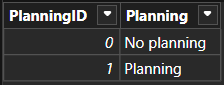

 - stockcontroltype: a que productos se realizara el control:
    - productos especificos, control general ó productos prioritarios.

  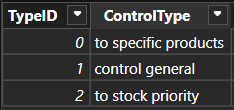

 - stockcontrolcheck: si el control fue realizado o no.

 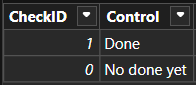


 - stockcontrolheader: tabla cabecera del control.

 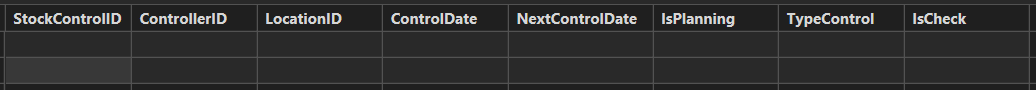

La tabla 'stockcontrolplanning' se realiza a continuación utilizando <font color="76A7FA">**BigQuery**</font>.

In [ ]:
# Tabla stockcontrolplanning
%%bigquery
DROP TABLE IF EXISTS `our-pursuit-431019-r0.adventureworks.stockcontrolplanning`;
CREATE TABLE `our-pursuit-431019-r0.adventureworks.stockcontrolplanning`(
              PlanningID   TINYINT NOT NULL,
              Planning     STRING  NOT NULL,
              PRIMARY KEY (PlanningID) NOT ENFORCED
              );

Query is running:   0%|          |

""


In [ ]:
%%bigquery
INSERT INTO `our-pursuit-431019-r0.adventureworks.stockcontrolplanning`
VALUES
  (0, "No planning") , (1, "Planning")
;

Query is running:   0%|          |

""


El resto de las tablas se realizaron con una conexión a <font color="#00758f">**My**</font><font color="#f29111">**SQL**</font> Workbench.

### Tabla 'stockcontrolheader'

A diferencia de las otras tablas creadas, esta tabla esta vacia.

A continuación se realizan los procedimientos para llenarla de los registros necesarios.

In [ ]:
# Productos prioritarios (controlados 2 veces al mes)
%%bigquery
SELECT * FROM `adventureworks.productinventory`
WHERE ProductID IN (
    SELECT ProductID FROM `adventureworks.stockcontrolfrecuency`
    WHERE Monthly_check = '2X'
          )
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,ProductID,LocationID,Quantity
0,951,5,348
1,828,6,432
2,958,7,128
3,963,7,126
4,751,7,32
5,752,7,52
6,956,7,35
7,789,7,112
8,960,7,54
9,759,7,112


In [ ]:
# En que lugar se encuentran los productos prioritarios?
%%bigquery
SELECT DISTINCT(LocationID)
FROM (
      SELECT *
      FROM `adventureworks.productinventory`
      WHERE ProductID
      IN (
          SELECT ProductID
          FROM `adventureworks.stockcontrolfrecuency`
          WHERE Monthly_check = '2X'
         )
      )
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,LocationID
0,5
1,6
2,7
3,10
4,20
5,30
6,40
7,45
8,50
9,60


In [ ]:
# Se utiliza una consulta en python para guardar el resultado en una variable (location).
from google.cloud import bigquery

# Crear un cliente de BigQuery
client = bigquery.Client()

In [ ]:
# Definir la consulta SQL
query = """
SELECT DISTINCT(LocationID)
FROM (
      SELECT *
      FROM `adventureworks.productinventory`
      WHERE ProductID
      IN (
          SELECT ProductID
          FROM `adventureworks.stockcontrolfrecuency`
          WHERE Monthly_check = '2X'
         )
      );
"""

# Ejecutar la consulta y guardar el resultado en un DataFrame de pandas
location = client.query(query).to_dataframe()

# Mostrar el DataFrame
print(location)


    LocationID
0            5
1            6
2            7
3           10
4           20
5           30
6           40
7           45
8           50
9           60
10           1


Confección de la primera fecha de control.

In [ ]:
# Definir la consulta SQL
query = """
SELECT DATE(CONCAT((SELECT EXTRACT(YEAR FROM MAX(OrderDate)) FROM `adventureworks.salesorderheader`),"-",
              (SELECT EXTRACT(MONTH FROM MAX(OrderDate)) FROM `adventureworks.salesorderheader`),
              "-14"));
"""

# Ejecutar la consulta y guardar el resultado en un DataFrame de pandas
date_init = client.query(query).to_dataframe()

# Mostrar el DataFrame
date_init.iloc[0,0]

datetime.date(2004, 7, 14)

Se guarda en una variable los identificadores de los empleados (EmployeeID), con el fin de utilizar uno de estos valores.

El objetivo es registrar que empleado realizó el control.

In [ ]:
# Definir la consulta SQL
query = """
SELECT EmployeeID FROM `adventureworks.employee`;
"""

# Ejecutar la consulta y guardar el resultado en un DataFrame de pandas
employee = client.query(query).to_dataframe()

# Mostrar el DataFrame
print(employee.head())

   EmployeeID
0         177
1          88
2         287
3          44
4         288


La tabla es llenada utilizando **mysql.connector** que permite trabajar a traves de una conexión desde este mismo notebook python hacia Cloud SQL.

A continuación se encuentran los procedimientos para llenar la tabla utilizando consultas de MySQL.

In [ ]:
# IP para entablar una conexión a CloudSQL
import requests

# Hacer una solicitud a un servicio que devuelve tu IP pública
ip = requests.get('https://api.ipify.org').text

ip

'34.95.213.19'

In [ ]:
!pip install mysql.connector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 78.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247952 sha256=fcdc35b8d55acd12040e2a381ddf2b2b4935fc19e4f17c3b0e76b534f9c747aa
  Stored in directory: /root/.cache/pip/wheels/76/48/9b/da67ff1a18fe8e9d428f9b1a177716d4a7d363d2bbe83bf6cf
Successfully built mysql.connector


In [ ]:
import mysql.connector

In [ ]:
from datetime import datetime, date, timedelta

Se llena la tabla con las locaciones, las fechas de control, el empleado y el resto de información.

para este caso las columnas ...

- IsPlanning = 1 (control planificado).
- TypeControl = 2 (control de productos prioritarios).
- IsCheck = 0 (todavía no se realizo el control).

In [ ]:
# Conectar a la base de datos MySQL
connection = mysql.connector.connect(
    host='35.199.92.51',
    user='aw-123',
    password='aw-123',
    database='adventureworks'
)

cursor = connection.cursor("LOCK TABLES `stockcontrolheader` WRITE")
# Poblar la tabla stockcontrolheader
for index, row in location.iterrows():

        sql_statements = f"""
        INSERT INTO `stockcontrolheader` ( ControllerID, LocationID, ControlDate, NextControlDate, IsPlanning, TypeControl, IsCheck)
        VALUES (91, {location.loc[index,"LocationID"]} , "{date_init.iloc[0,0]}", "{date_init.iloc[0,0]+ timedelta(days = 30)}" , 1 , 2, 0);
        """

        cursor.execute(sql_statements)

cursor.execute("UNLOCK TABLES")
# Confirmar los cambios
connection.commit()
cursor.close()
connection.close()

In [ ]:
# Conectar a la base de datos MySQL
connection = mysql.connector.connect(
    host='35.199.92.51',
    user='aw-123',
    password='aw-123',
    database='adventureworks'
)

cursor = connection.cursor()
# Ejecutar consulta, muestra los registros insertados
sql_statements = """
        SELECT * FROM `stockcontrolheader`;
        """
cursor.execute(sql_statements)
for row in cursor.fetchall():
    print(row)

# Cerrar la conexión
cursor.close()
connection.close()

Resultado
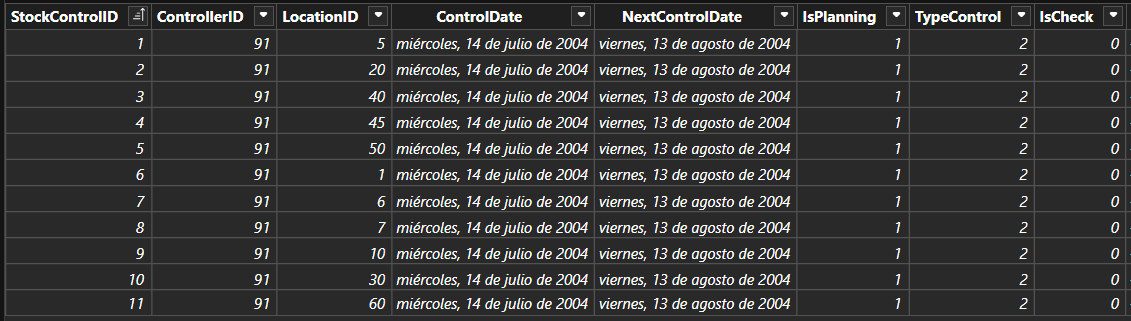

A continuación se crea una función para llenar la tabla con el resto de los registros.

In [ ]:
import bigframes.pandas as bf

bf.options.bigquery.location = "US"
bf.options.bigquery.project = "our-pursuit-431019-r0"

In [ ]:
# Función para llenar la tabla stockcontrolheader
def input_sch(typecontrol=int, y=int , m=int, d=int, isplanning=True, prodID_list=list):

  """
  Poblar de registros la tabla stockcontrolheader.

  INPUT:
    typecontrol (0,1,2): tipo de control según la tabla stockcontroltype.
    y: año del control.
    m: mes del control.
    d: día del control.
    isplanning (0,1): si el control es planeado o no según la tabla stockcontrolplanning.
    prodID_list: ID de los productos a controlar.

  OUTPUT:
    Inserta los nuevos registros a la tabla stockcontrolheader.
  """

  if typecontrol not in (0,1,2):
    raise ValueError("typecontrol invalid value")

  controldate = date(year=y, month=m , day=d).strftime('%Y-%m-%d')

  df = bf.read_gbq("our-pursuit-431019-r0.adventureworks.stockcontrolheader")
  a = df['TypeControl'] == typecontrol
  b = df['ControlDate'] == controldate

  if df[a & b].empty:

    where = (
        f"WHERE ProductID IN {tuple(prodID_list)}" if typecontrol == 0 and prodID_list
        else "WHERE Monthly_check = '2X'" if typecontrol == 2
        else ""  # Para typecontrol == 1
          )

    query = f"""
              SELECT DISTINCT(LocationID)
              FROM (
                    SELECT *
                    FROM `adventureworks.productinventory`
                    WHERE ProductID
                    IN (
                        SELECT ProductID
                        FROM `adventureworks.stockcontrolfrecuency`
                        {where}
                        )
                    );
              """

    location = client.query(query).to_dataframe()

  connection = mysql.connector.connect(
                host='35.199.92.51',
                user='aw-123',
                password='aw-123',
                database='adventureworks'
                )

  cursor = connection.cursor("LOCK TABLES `stockcontrolheader` WRITE")
  # Poblar la tabla stockcontrolheader
  p = 1 if isplanning else 0
  for index, row in location.iterrows():

            sql_statements = f"""
            INSERT INTO `stockcontrolheader` ( ControllerID, LocationID, ControlDate, NextControlDate, IsPlanning, TypeControl, IsCheck)
            VALUES (91, {location.loc[index,"LocationID"]}, "{controldate}", "{controldate + timedelta(days = 30)}", {p}, {typecontrol}, 0);
            """

            cursor.execute(sql_statements)

  cursor.execute("UNLOCK TABLES")
  # Confirmar los cambios
  connection.commit()
  cursor.close()
  connection.close()

In [ ]:
bf.close_session()

### Tabla stockcontroldetail.
En esta tabla se alojara la información acerca de los productos y la cantidad de unidades disponibles.

A diferencia del resto de las tablas, esta tabla se confecciona mediante un dataframe y se guarda en un archivo CSV para luego ser ejecutada como hoja de cálculo tipo Excel o Google Sheets (spreadsheet).

El objetivo es interactuar con las celdas, marcar la inspección y, si existen, anomalias en las cantidades (faltantes o excesos).

In [ ]:
import pandas as pd

In [ ]:
# Creación de la tabla stockcontroldetail
def stockcontrol(id = int, y=int , m=int, d=int):
  """
  Crea una dataframe para llevar el control de los productos.
  INPUT:
      id: StockControID.
      y: año.
      m: mes.)
      d: día.
  OUTPUT:
      dataframe.
          ProductID: producto.
          Quantity: unidades disponibles.
          Check: si se realizó, o no, la inspección del producto.
          Observations_ID##: detalles u observaciones relevantes, excesos, faltantes, etc.
  """

  controldate = date(year=y, month=m , day=d).strftime('%Y-%m-%d')
  # Crear un cliente de BigQuery
  client = bigquery.Client()

  query = f"""
    SELECT LocationID
    FROM `adventureworks.stockcontrolheader`
    WHERE StockControlID = {id} AND ControlDate ='{controldate}';
    """
  # Ejecutar la consulta y guardar el resultado en un DataFrame de pandas
  try:
    location = client.query(query).to_dataframe().iloc[0,0]
    query = f"""
    SELECT ProductID, Quantity
    FROM `adventureworks.productinventory`
    WHERE LocationID = {location};
    """
    prod_qty = client.query(query).to_dataframe()

    stockcontroldetail_dicc = {
        'ProductID': prod_qty.iloc[:,0],
        'Quantity': prod_qty.iloc[:,1],
        'Check': "",
        f'Observations_ID{id}': ""
    }

    stockcontroldetail = pd.DataFrame(stockcontroldetail_dicc)
    return stockcontroldetail

  except:
    print('id or datecontrol invalue')

In [ ]:
test =stockcontrol(1, 2004 ,7, 14)
test.head()

,ProductID,Quantity,Check,Observations_ID1
0,949,336,,
1,951,348,,
2,945,347,,
3,816,406,,
4,948,347,,


In [ ]:
# Guardar stockcontroldetail en un CSV.
def spreadsheets (id = int, y=int , m=int, d=int):
  """
  Crea un archivo CSV del dataframe.
  INPUT:
      id: StockControID.
      y: año.
      m: mes.
      d: día.
  OUTPUT:
      Archivo CSV llamado 'StockControl_id.csv'.
  """
  ss= stockcontrol(id, y ,m, d)
  return ss.to_csv(f'StockControl_{id}.csv')

In [ ]:
test = spreadsheets(1, 2004 ,7, 14)

Resultado visto desde un archivo excel:

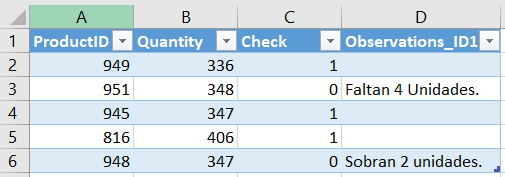